In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score
)
from sklearn.neighbors import NearestNeighbors

# Plot & random config
sns.set_context("notebook")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Setup complete.")

Setup complete.


In [2]:
from google.colab import files
uploaded = files.upload()

df=pd.read_csv("Mall_Customers.csv")
df.head()

Saving Mall_Customers.csv to Mall_Customers.csv


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
print("\nInfo:")
df.info()

print("\nDescriptive statistics:")
display(df.describe(include="all"))

print(f"\nShape: {df.shape}")


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive statistics:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000



Shape: (200, 5)


In [4]:
print("Missing values per column:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

# Drop duplicates if any
df = df.drop_duplicates().copy()

# Drop CustomerID if present (not useful for clustering)
if "CustomerID" in df.columns:
    df.drop(columns=["CustomerID"], inplace=True)

# Rename numeric columns for convenience
df = df.rename(columns={
    "Annual Income (k$)": "Annual Income",
    "Spending Score (1-100)": "Spending Score"
})

# Keep gender as a label for plotting, and create a numeric version for analytics
df["Gender_label"] = df["Gender"]
df["Gender_num"]   = df["Gender_label"].map({"Male": 1, "Female": 0})

# Simple feature engineering
df["Spend_Income_Ratio"] = df["Spending Score"] / (df["Annual Income"] + 1e-9)

# Base features for visuals; extended for clustering
features_base = ["Age", "Annual Income", "Spending Score"]
features_ext  = features_base + ["Spend_Income_Ratio"]

print("\nShape after cleaning:", df.shape)
display(df.head())

Missing values per column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Duplicates: 0

Shape after cleaning: (200, 7)


,Gender,Age,Annual Income,Spending Score,Gender_label,Gender_num,Spend_Income_Ratio
0,Male,19,15,39,Male,1,2.600000
1,Male,21,15,81,Male,1,5.400000
2,Female,20,16,6,Female,0,0.375000
3,Female,23,16,77,Female,0,4.812500
4,Female,31,17,40,Female,0,2.352941


**GENDER DISTRIBUTION**

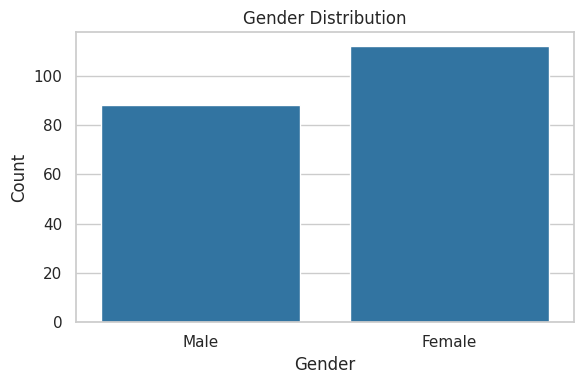

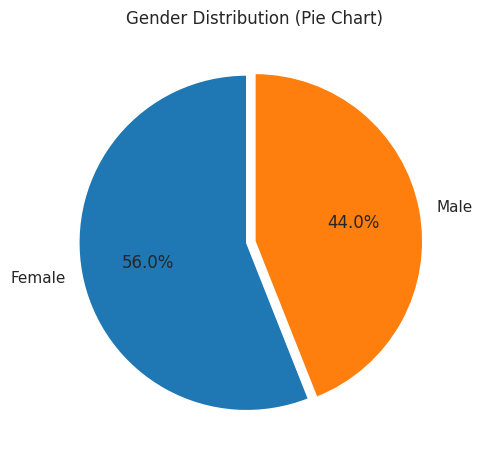

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Gender_label", data=df)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Pie chart for Gender
values = df["Gender_label"].value_counts()
labels = values.index

plt.figure(figsize=(5, 5))
plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    explode=(0.05, 0)
)
plt.title("Gender Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

Gender is equally balanced, with one gender slightly more than the other. So strategies should be made in a way that targets both the genders equally.

**CORRELATION MATRIX**

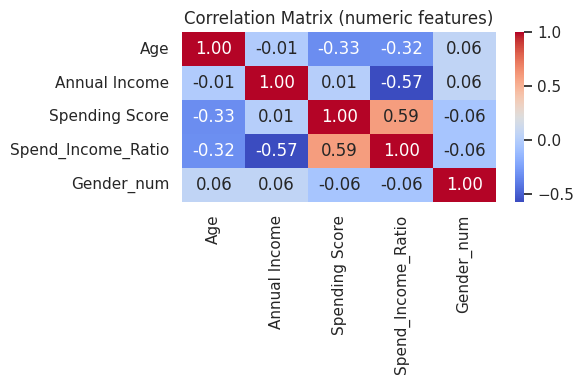

In [6]:
corr_cols = ["Age", "Annual Income", "Spending Score", "Spend_Income_Ratio", "Gender_num"]
plt.figure(figsize=(6, 4))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()

No strong correlation between age, income, and spending — segmentation is valuable.

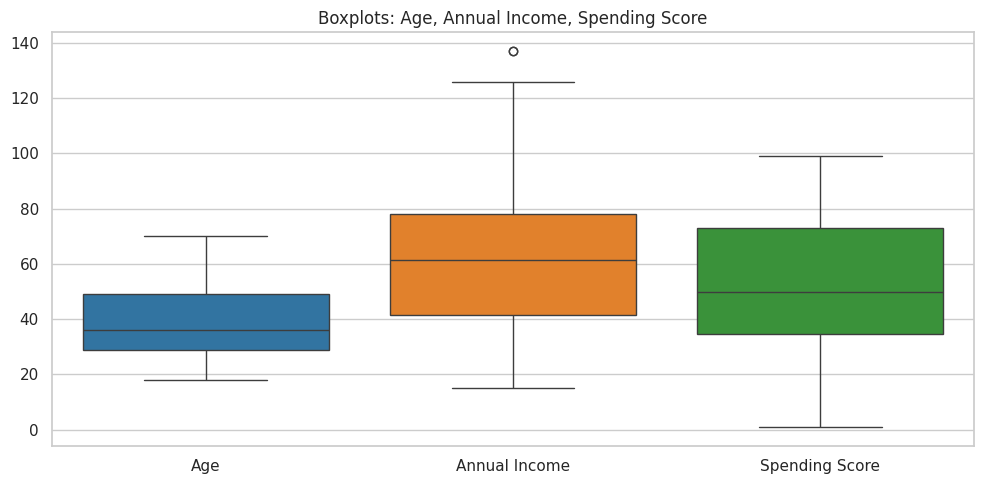

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Age", "Annual Income", "Spending Score"]])
plt.title("Boxplots: Age, Annual Income, Spending Score")
plt.tight_layout()
plt.show()


Some outliers in income and spending. Most values are in the middle range.

**HISTOGRAMS:**

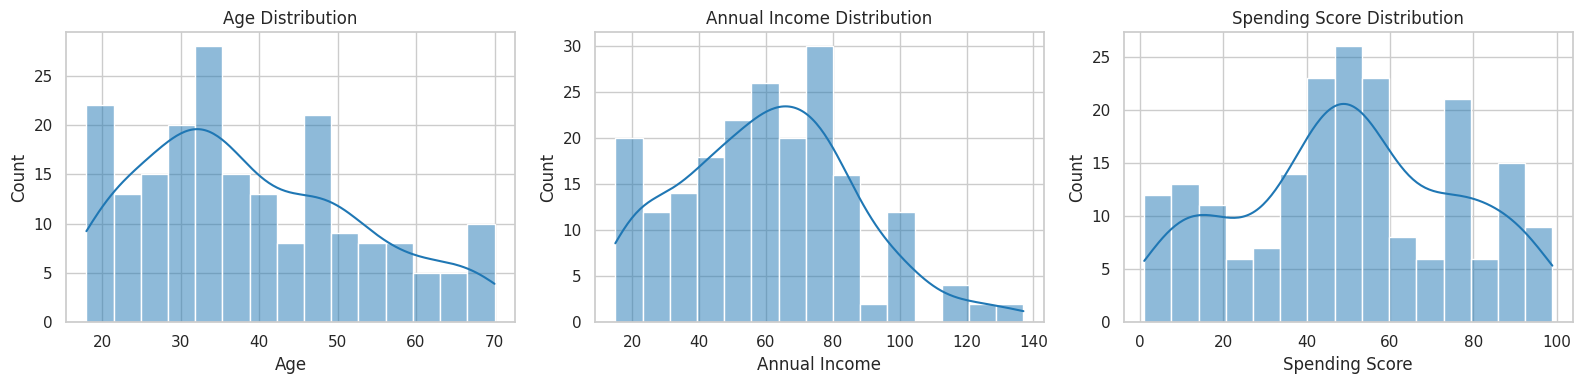

In [8]:
plt.figure(figsize=(16, 4))
for i, col in enumerate(["Age", "Annual Income", "Spending Score"]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], bins=15, kde=True)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()


Most customers are young adults; income and spending are widely spread.

EDA insights (age, income, spending)
1. Age: mainly young and middle-aged adults, with relatively few seniors.
2. Annual Income: concentrated in the mid range, with a tail of higher-income   customers.
3. Spending Score: spread across the full range, which is ideal for segmentation.

These patterns confirm that unsupervised learning is useful: the data does not show obvious bands by eye, but clustering can compress this diversity into a small number of actionable groups.


**PAIRPLOT(BY GENDER)**

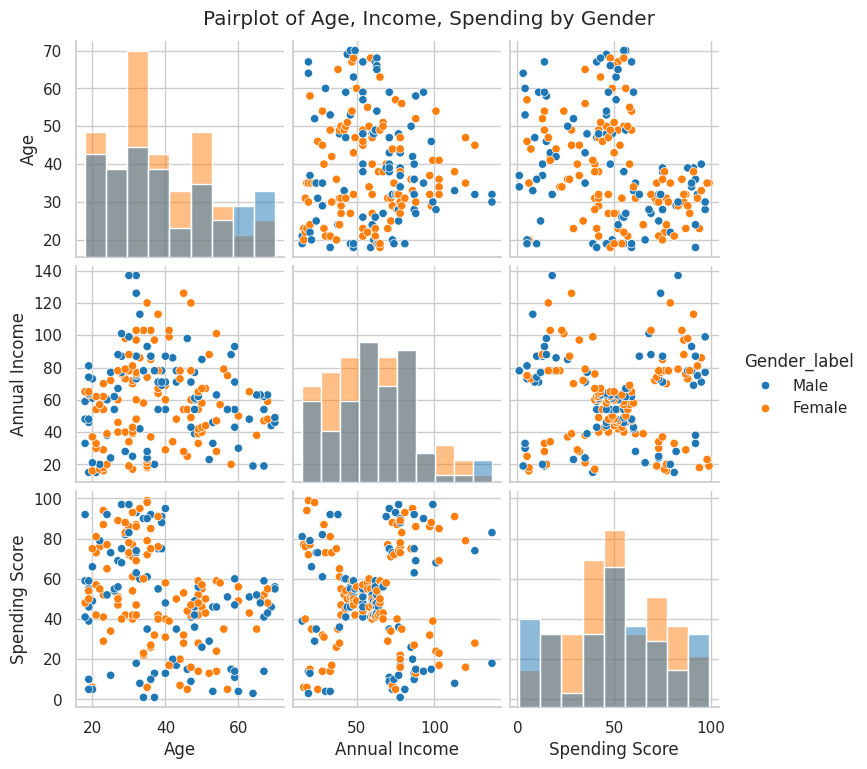

In [9]:
sns.pairplot(
    df,
    vars=["Age", "Annual Income", "Spending Score"],
    hue="Gender_label",
    height=2.5,
    diag_kind="hist"
)
plt.suptitle("Pairplot of Age, Income, Spending by Gender", y=1.02)
plt.show()

The pairplot shows that age, income, and spending are weakly related. Customers with similar income or age behave very differently in terms of spending. Gender also does not create meaningful separation. This confirms that customer behavior is multi-dimensional, making unsupervised clustering necessary to uncover actionable segments.

Scaling For Clustering


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_ext])

print("Features used for clustering:", features_ext)
print("Scaled shape:", X_scaled.shape)

Features used for clustering: ['Age', 'Annual Income', 'Spending Score', 'Spend_Income_Ratio']
Scaled shape: (200, 4)


Selected best_k by silhouette (auto) = 6
Using fixed k = 6 clusters for interpretability.


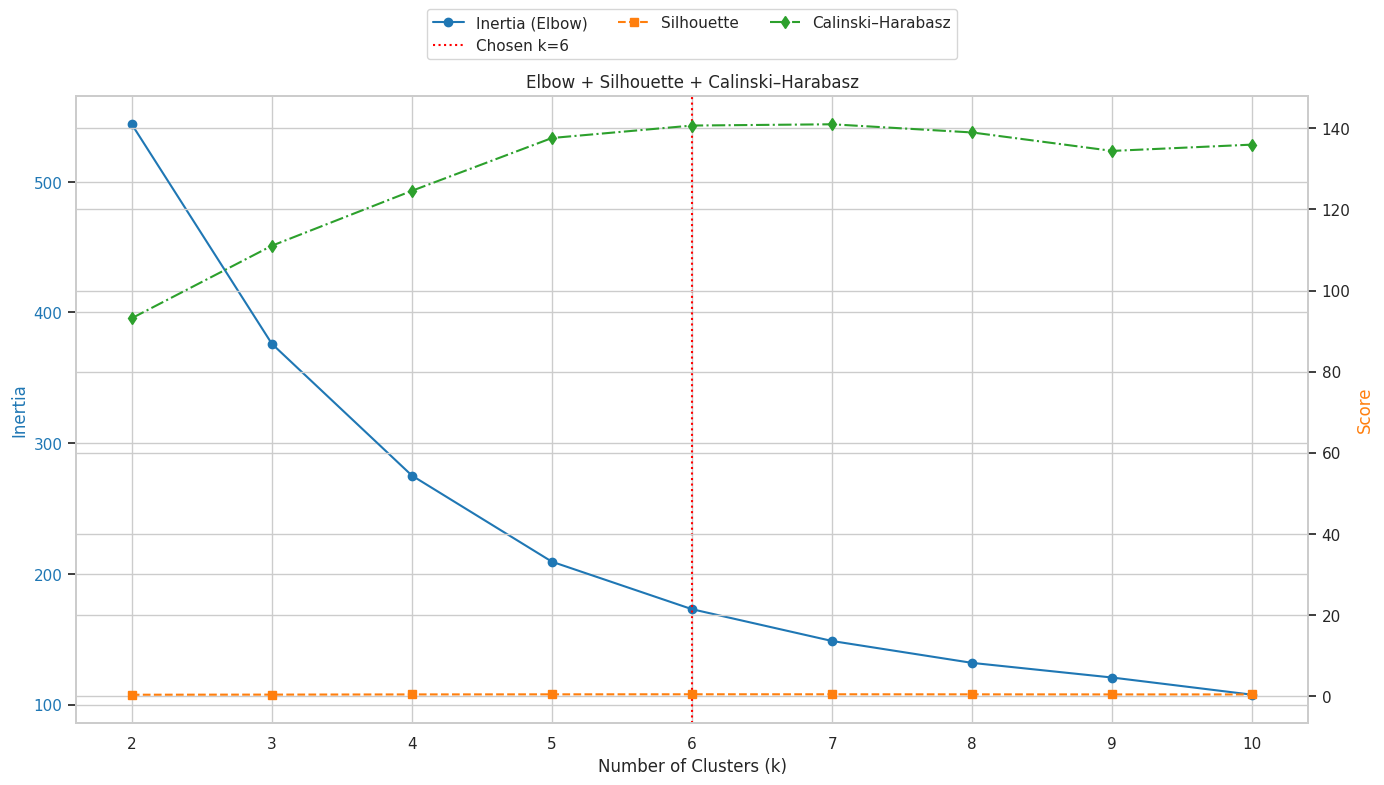

In [11]:
# K Selection
ks = range(2, 11)
inertias, sil_scores, ch_scores = [], [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

best_k_auto = ks[np.argmax(sil_scores)]
print(f"Selected best_k by silhouette (auto) = {best_k_auto}")

# Fix k=6 for stable interpretability and persona naming
best_k = 6
print(f"Using fixed k = {best_k} clusters for interpretability.")

# Plot curves
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia", color="tab:blue")
ax1.plot(ks, inertias, "o-", color="tab:blue", label="Inertia (Elbow)")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Score", color="tab:orange")
ax2.plot(ks, sil_scores, "s--", color="tab:orange", label="Silhouette")
ax2.plot(ks, ch_scores, "d-.", color="tab:green", label="Calinski–Harabasz")

ax1.axvline(best_k, ls=":", color="red", label=f"Chosen k={best_k}")

lines, labels = [], []
for ax in (ax1, ax2):
    L, lab = ax.get_legend_handles_labels()
    lines += L
    labels += lab

ax1.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.title("Elbow + Silhouette + Calinski–Harabasz")
plt.tight_layout()
plt.show()

Silhouette Score: 0.425
Davies–Bouldin Score: 0.831



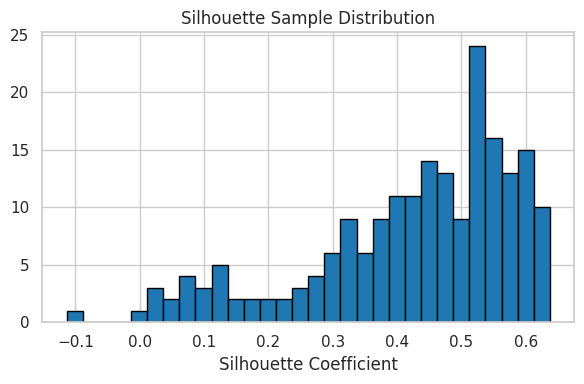

In [12]:
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

sil = silhouette_score(X_scaled, df["Cluster"])
db_score = davies_bouldin_score(X_scaled, df["Cluster"])

print(f"Silhouette Score: {sil:.3f}")
print(f"Davies–Bouldin Score: {db_score:.3f}\n")

# Silhouette samples: histogram
sample_sil = silhouette_samples(X_scaled, df["Cluster"])
plt.figure(figsize=(6, 4))
plt.hist(sample_sil, bins=30, edgecolor="k")
plt.xlabel("Silhouette Coefficient")
plt.title("Silhouette Sample Distribution")
plt.tight_layout()
plt.show()

Most customers clearly belong to a cluster, a few sit near boundaries, and overall the segmentation is meaningful and stable.


The silhouette score of 0.425 indicates reasonably well-separated clusters, which is typical for real-world customer segmentation. The Davies–Bouldin score below 1 further confirms compact and distinct clusters. The silhouette distribution shows most points have positive coefficients, meaning customers are correctly assigned, with only a small number of borderline cases.

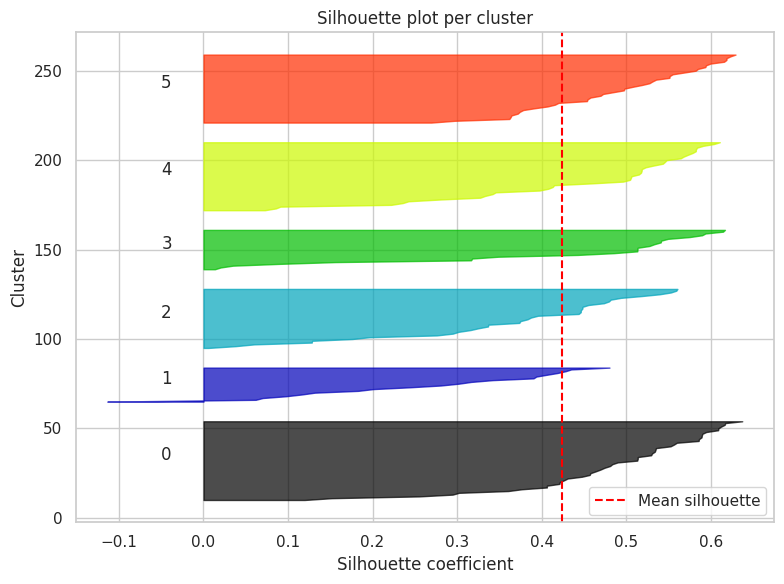

In [13]:
def plot_silhouette_per_cluster(X, labels):
    n_clusters = len(np.unique(labels))
    sample_sil = silhouette_samples(X, labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10

    for c in range(n_clusters):
        vals_c = sample_sil[labels == c]
        vals_c.sort()
        size_c = vals_c.shape[0]
        y_upper = y_lower + size_c

        color = cm.nipy_spectral(float(c) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            vals_c,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_c, str(c))
        y_lower = y_upper + 10  # space between clusters

    ax.axvline(sample_sil.mean(), color="red", linestyle="--", label="Mean silhouette")
    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster")
    ax.set_title("Silhouette plot per cluster")
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_silhouette_per_cluster(X_scaled, df["Cluster"].values)


The cluster-wise silhouette plot shows how tight and well-separated each segment is. Most customers have positive silhouette values, and the mean silhouette (red vertical line) indicates overall clustering quality.

In [14]:
from sklearn.metrics import adjusted_rand_score

def stability_ari(X, k=6, seeds=[10, 20, 30, 40, 50]):
    labels_list = []
    for sd in seeds:
        km = KMeans(n_clusters=k, random_state=sd, n_init=10)
        labels_list.append(km.fit_predict(X))

    base = labels_list[0]
    ari_scores = []
    for other in labels_list[1:]:
        ari_scores.append(adjusted_rand_score(base, other))

    print("ARI scores vs first run:", [f"{s:.3f}" for s in ari_scores])
    print(f"Mean ARI stability = {np.mean(ari_scores)*100:.1f}%")

# Run stability test
stability_ari(X_scaled, k=best_k)

ARI scores vs first run: ['1.000', '1.000', '1.000', '1.000']
Mean ARI stability = 100.0%


The six-cluster solution is fully stable and robust

**Quick Algorithm Comparison (Agglomerative & GMM)**

In [15]:
# Algorithm comparison
agg = AgglomerativeClustering(n_clusters=best_k).fit(X_scaled)
gmm = GaussianMixture(n_components=best_k, random_state=RANDOM_STATE).fit(X_scaled)

comp = pd.DataFrame({
    "Algorithm": [
        f"KMeans(k={best_k})",
        f"Agglo(k={best_k})",
        f"GMM(n={best_k})"
    ],
    "Silhouette": [
        silhouette_score(X_scaled, df["Cluster"]),
        silhouette_score(X_scaled, agg.labels_),
        silhouette_score(X_scaled, gmm.predict(X_scaled))
    ],
    "DaviesBouldin": [
        davies_bouldin_score(X_scaled, df["Cluster"]),
        davies_bouldin_score(X_scaled, agg.labels_),
        davies_bouldin_score(X_scaled, gmm.predict(X_scaled))
    ],
    "CalinskiHarabasz": [
        calinski_harabasz_score(X_scaled, df["Cluster"]),
        calinski_harabasz_score(X_scaled, agg.labels_),
        calinski_harabasz_score(X_scaled, gmm.predict(X_scaled))
    ]
}).round(3)

print("\n=== Algorithm Comparison ===")
display(comp)


=== Algorithm Comparison ===


,Algorithm,Silhouette,DaviesBouldin,CalinskiHarabasz
0,KMeans(k=6),0.425,0.831,140.680
1,Agglo(k=6),0.405,0.827,126.037
2,GMM(n=6),0.366,0.926,106.721


KMeans is kept as the main clustering algorithm due to its balance of performance and interpretability, while Agglomerative and GMM provide useful sanity checks and alternative views on cluster structure.

**PCA for Visualization**

PCA (2D) explains ~78.4% of variance



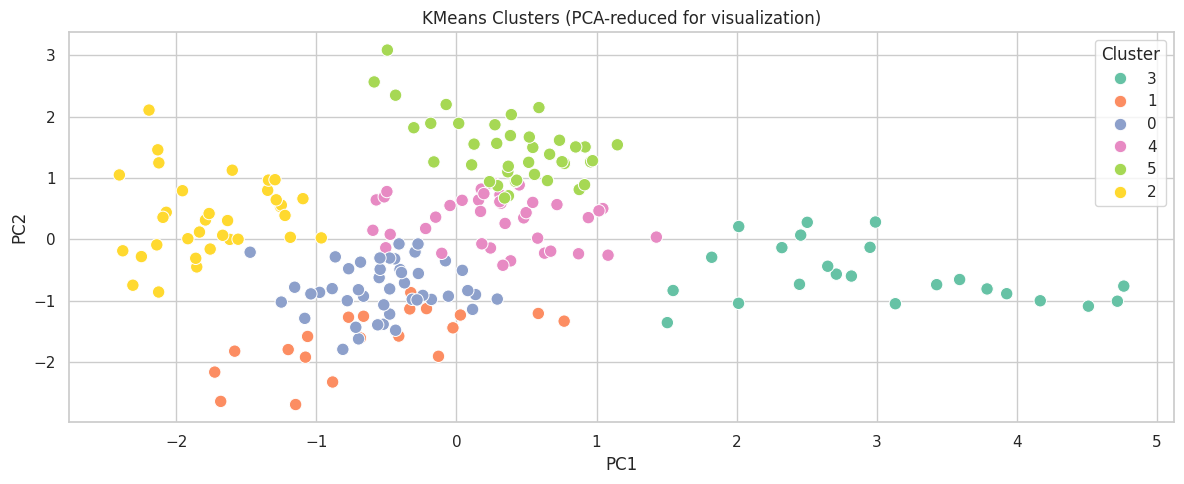

In [16]:
# PCA (2D) for Visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
var2 = pca.explained_variance_ratio_.sum()
print(f"PCA (2D) explains ~{var2*100:.1f}% of variance\n")

# PCA scatter by cluster
plt.figure(figsize=(12, 5))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df["Cluster"].astype(str),
    palette="Set2",
    s=80
)
plt.title("KMeans Clusters (PCA-reduced for visualization)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

We used PCA to project the high-dimensional data into two dimensions for visualization. The first two components explain about 78% of the variance. The plot shows that customers assigned to the same KMeans cluster form compact and mostly well-separated groups, visually confirming the quality of the segmentation.

**Income Vs Spending Scatter**

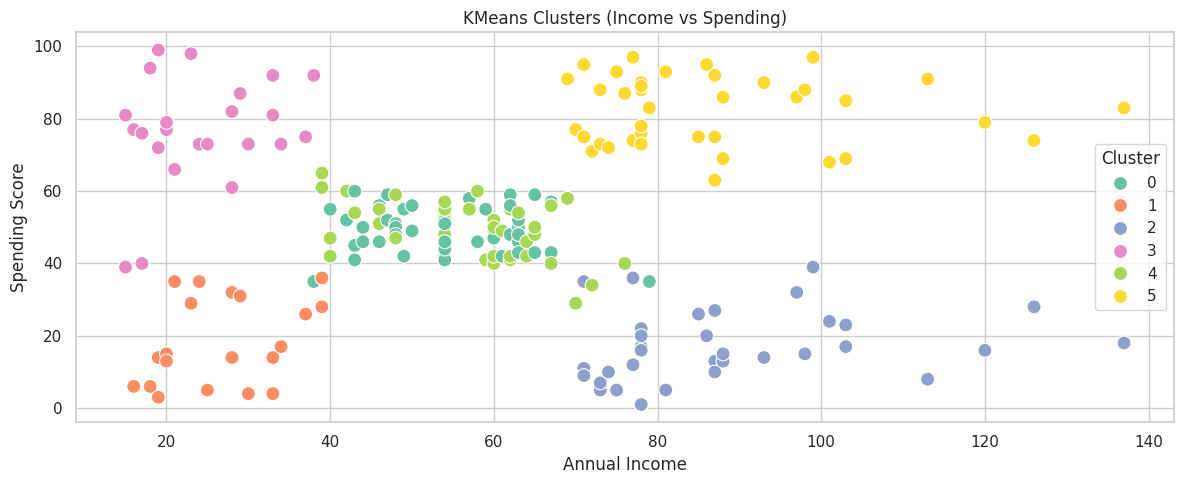

In [17]:
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df,
    x="Annual Income",
    y="Spending Score",
    hue="Cluster",
    palette="Set2",
    s=100
)
plt.title("KMeans Clusters (Income vs Spending)")
plt.tight_layout()
plt.show()

**Overlay Centroids on Income vs Spending**

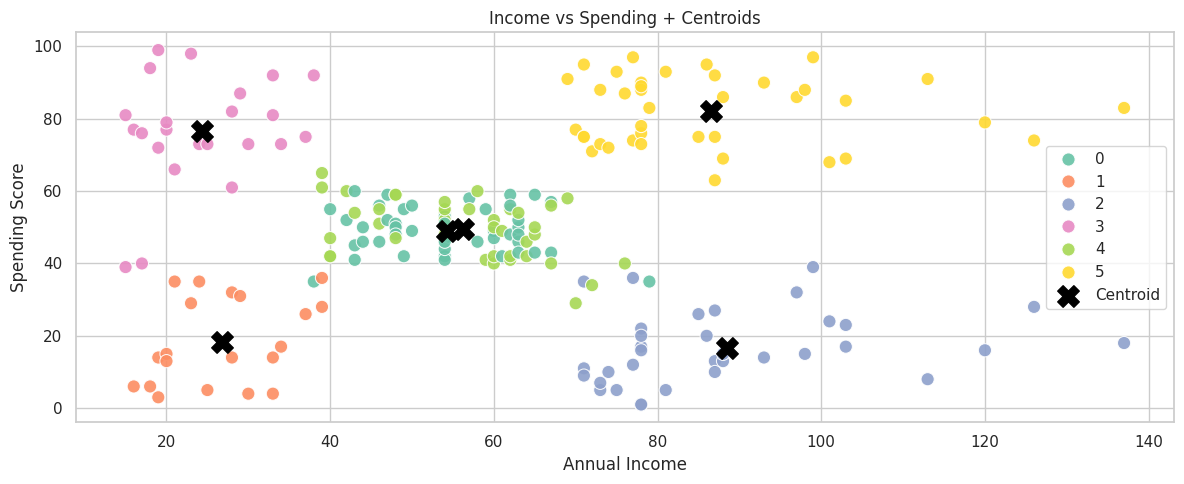

In [18]:
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)

ix_inc = features_ext.index("Annual Income")
ix_spd = features_ext.index("Spending Score")

plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df,
    x="Annual Income",
    y="Spending Score",
    hue="Cluster",
    palette="Set2",
    s=90,
    alpha=0.9
)
plt.scatter(
    centers_orig[:, ix_inc],
    centers_orig[:, ix_spd],
    c="black",
    s=240,
    marker="X",
    label="Centroid"
)
plt.title("Income vs Spending + Centroids")
plt.legend()
plt.tight_layout()
plt.show()

**Cluster Profiles**

In [19]:
profile = df.groupby("Cluster").agg({
    "Age": "mean",
    "Annual Income": "mean",
    "Spending Score": "mean",
    "Spend_Income_Ratio": "mean",
    "Gender_num": "mean",
    "Cluster": "count"
}).rename(columns={"Cluster": "Count"}).round(1)

profile["%Male"] = (profile["Gender_num"] * 100).round(1)
profile = profile.drop(columns=["Gender_num"])

print("\n==== Cluster Profiles ====")
display(profile)


==== Cluster Profiles ====


,Age,Annual Income,Spending Score,Spend_Income_Ratio,Count,%Male
Cluster,,,,,,
0,56.3,54.3,49.1,0.9,45,40.0
1,46.2,26.8,18.4,0.7,20,40.0
2,41.3,88.5,16.8,0.2,34,60.0
3,25.3,24.3,76.5,3.4,23,40.0
4,26.9,56.2,49.5,0.9,39,30.0
5,32.7,86.5,82.1,1.0,39,50.0


**Cluster Feature Heatmap**

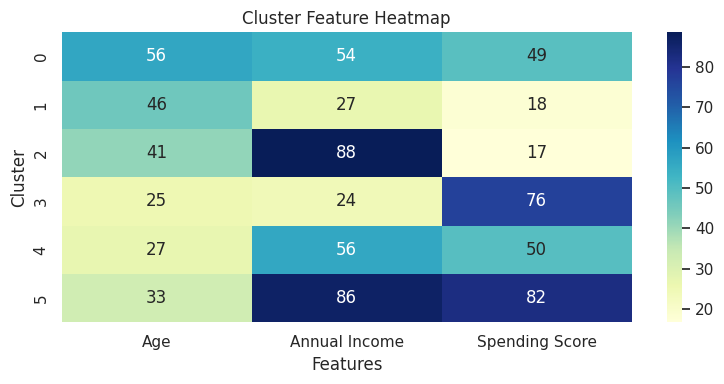

In [20]:
heatmap_data = profile[["Age", "Annual Income", "Spending Score"]]

plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Cluster Feature Heatmap")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

**Bar Plot for Cluster Sizes**

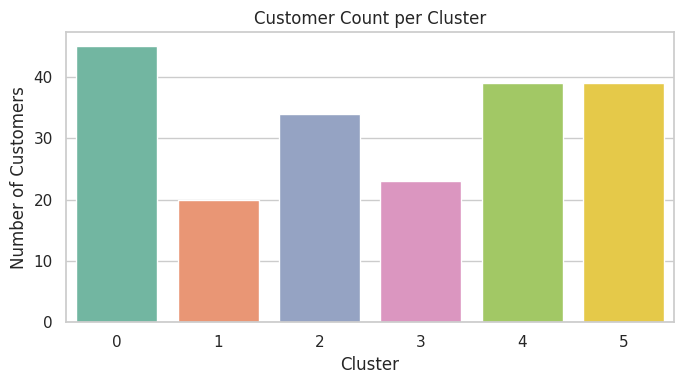

In [21]:
plt.figure(figsize=(7, 4))
sns.barplot(
    x=profile.index.astype(str),
    y=profile["Count"],
    palette="Set2"
)
plt.title("Customer Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

This bar plot illustrates the number of customers in each cluster, helping to gauge the potential business impact of targeting each segment.

**Gender distribution per cluster (stacked bar)**

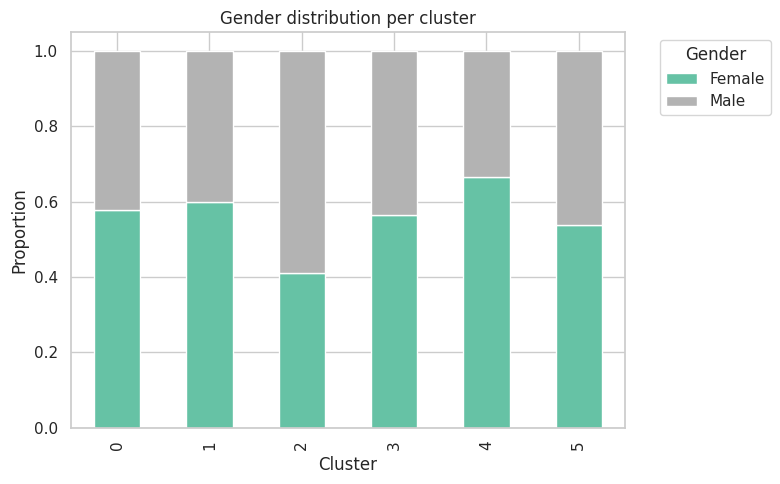

In [22]:
ct = pd.crosstab(df["Cluster"], df["Gender_label"])
ct_norm = ct.div(ct.sum(axis=1), axis=0)

ax = ct_norm.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    colormap="Set2"
)
plt.title("Gender distribution per cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

This chart shows the gender composition inside each cluster. Some segments are more balanced, while others lean toward one gender, which helps tailor marketing tone, visuals, and campaigns more effectively.

**Age distribution per cluster (violin plot)**

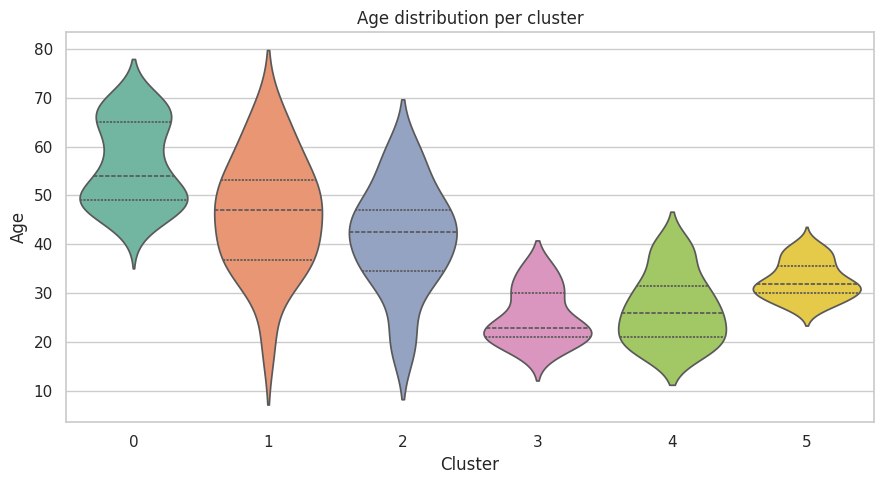

In [23]:
plt.figure(figsize=(9, 5))
sns.violinplot(
    data=df,
    x="Cluster",
    y="Age",
    palette="Set2",
    inner="quartile"
)
plt.title("Age distribution per cluster")
plt.xlabel("Cluster")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

Age distribution varies clearly across clusters. Some segments are dominated by younger shoppers while others attract older customers, reinforcing the persona definitions and guiding age-targeted marketing strategies.

**Radar Charts for Cluster Profiles**

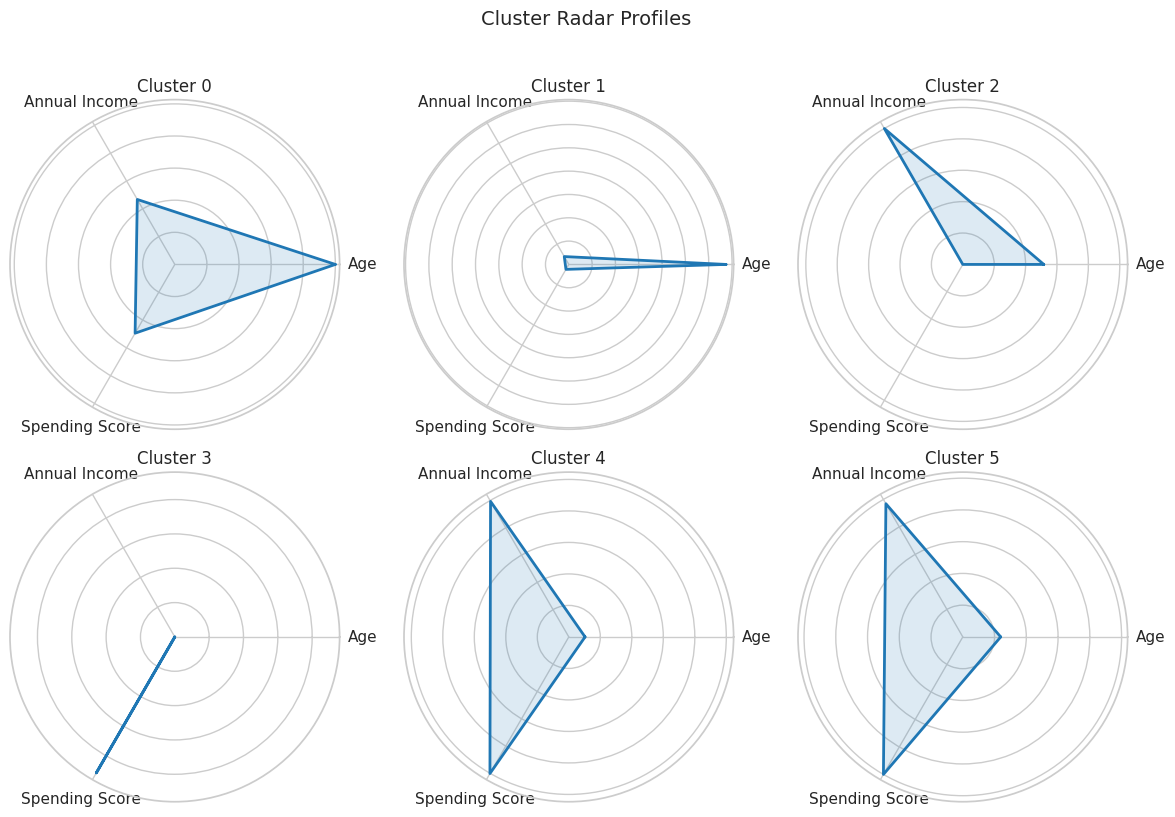

In [24]:
def radar_charts(profile_df, features=("Age", "Annual Income", "Spending Score"),
                 title="Cluster Radar Profiles"):
    data = profile_df[list(features)].copy()
    data_norm = (data - data.min()) / (data.max() - data.min() + 1e-9)

    labels = list(features)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    n_clusters = data_norm.shape[0]
    n_cols = min(3, n_clusters)
    n_rows = int(np.ceil(n_clusters / n_cols))

    fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))
    fig.suptitle(title, y=1.02, fontsize=14)

    for idx, (cl, row) in enumerate(data_norm.iterrows(), start=1):
        vals = row.values.tolist()
        vals += vals[:1]
        ax = plt.subplot(n_rows, n_cols, idx, polar=True)
        ax.plot(angles, vals, linewidth=2)
        ax.fill(angles, vals, alpha=0.15)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels)
        ax.set_yticklabels([])
        ax.set_title(f"Cluster {cl}")

    plt.tight_layout()
    plt.show()

radar_charts(profile[["Age", "Annual Income", "Spending Score"]])

The radar charts compare clusters across Age, Income, and Spending on the same scale. Each cluster has a distinct shape, making it easy to see which groups are younger, wealthier, or higher spenders at a glance.

**Spend_Income_Ratio vs Age by cluster**

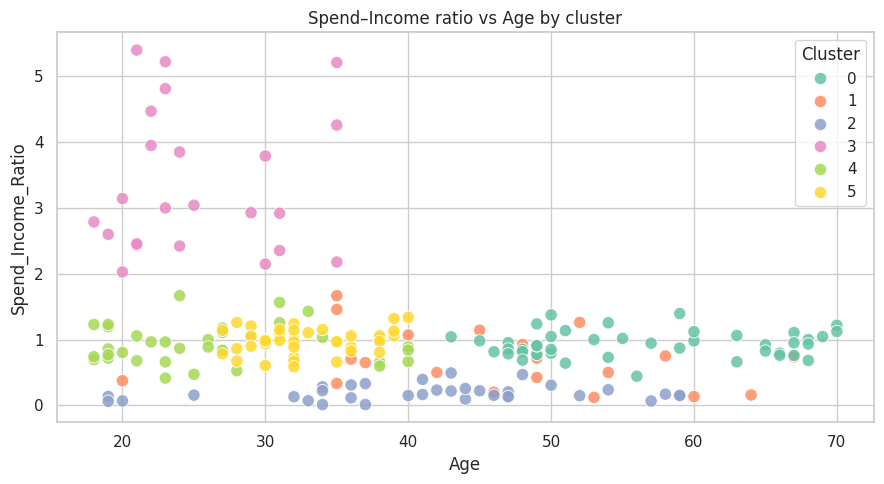

In [25]:
plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=df,
    x="Age",
    y="Spend_Income_Ratio",
    hue="Cluster",
    palette="Set2",
    s=80,
    alpha=0.85
)
plt.title("Spend–Income ratio vs Age by cluster")
plt.xlabel("Age")
plt.ylabel("Spend_Income_Ratio")
plt.tight_layout()
plt.show()

The spend–income ratio reveals which age groups tend to overspend relative to their income. Younger customers often show higher ratios, while older segments display more controlled spending patterns. This helps identify high-potential and high-risk groups.

**Pairplot by Cluster (Original Features)**

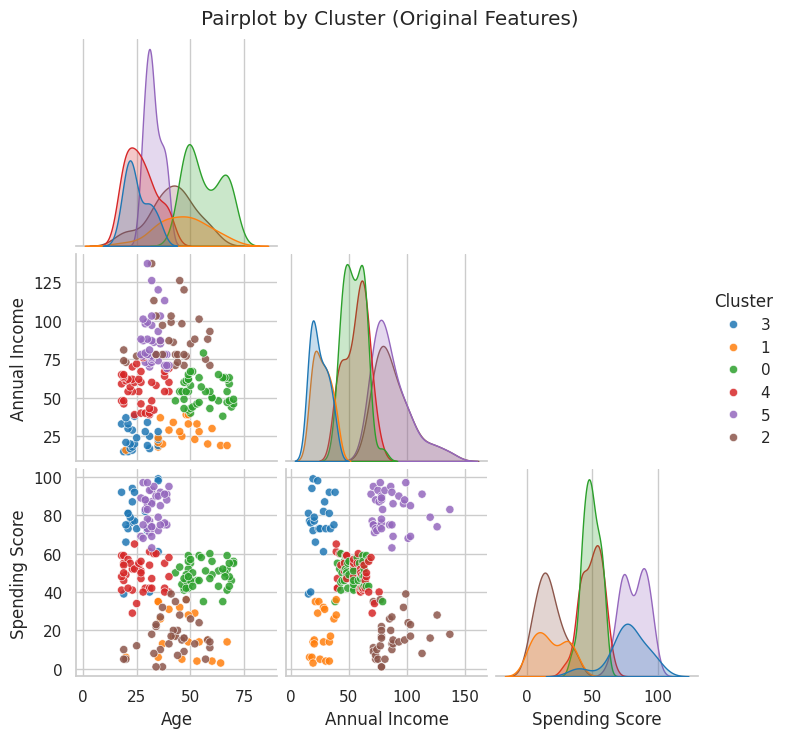

In [26]:
df_pp = df.copy()
df_pp["Cluster"] = df_pp["Cluster"].astype(str)

sns.pairplot(
    df_pp,
    vars=["Age", "Annual Income", "Spending Score"],
    hue="Cluster",
    height=2.4,
    corner=True,
    plot_kws=dict(s=35, alpha=0.85)
)
plt.suptitle("Pairplot by Cluster (Original Features)", y=1.02)
plt.show()

The pairplot shows how clusters differ across Age, Income, and Spending. Some clusters appear clearly separated, while others overlap slightly, indicating mixed behaviors.

**Pairplot including PCA axes**

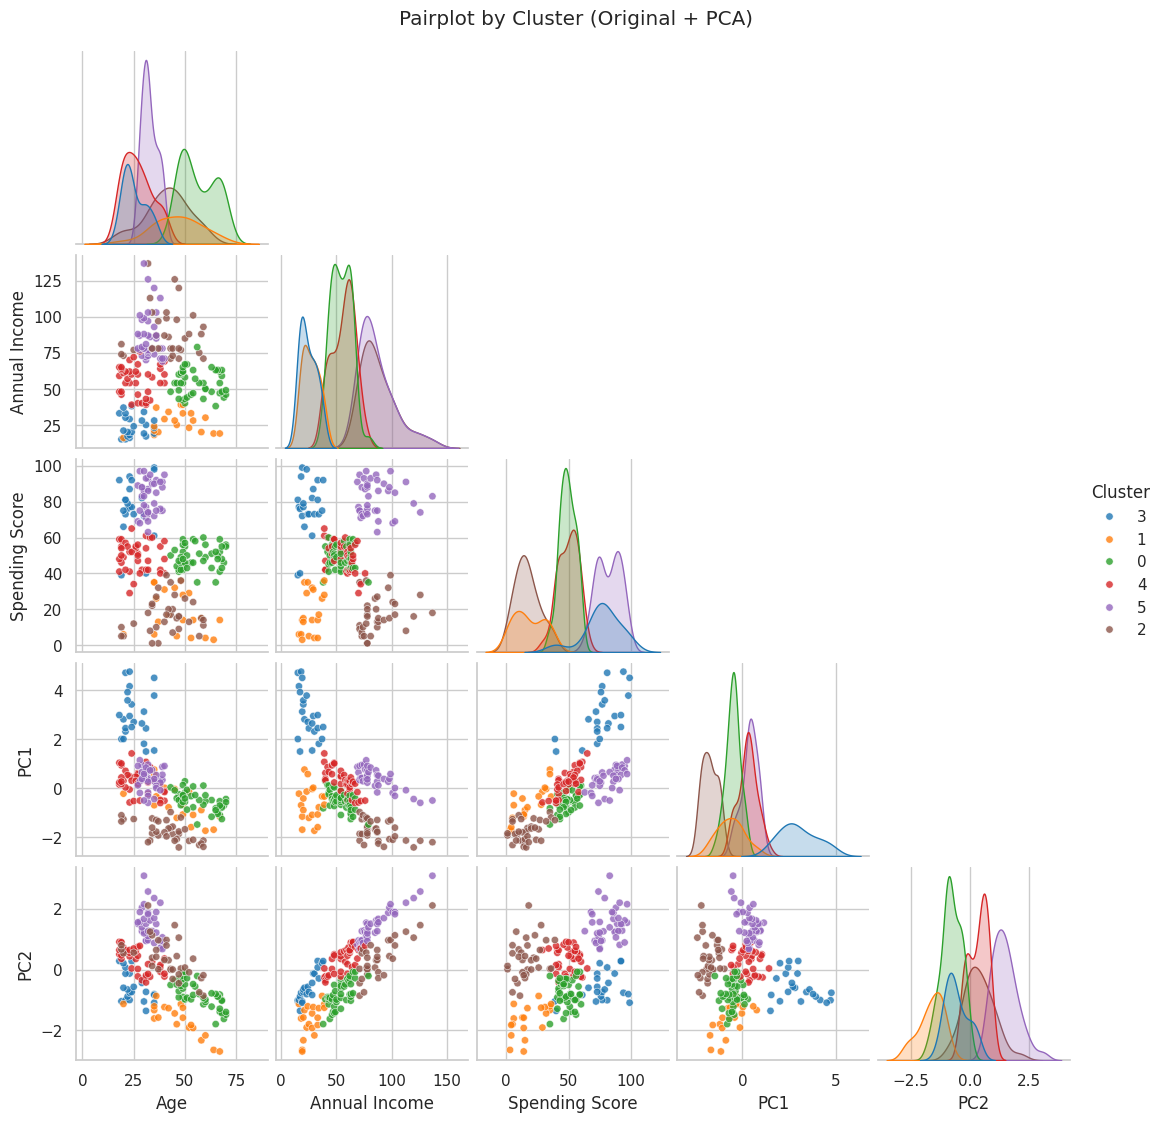

In [27]:
df_pp2 = df.copy()
df_pp2["PC1"] = X_pca[:, 0]
df_pp2["PC2"] = X_pca[:, 1]
df_pp2["Cluster"] = df_pp2["Cluster"].astype(str)

sns.pairplot(
    df_pp2,
    vars=["Age", "Annual Income", "Spending Score", "PC1", "PC2"],
    hue="Cluster",
    height=2.2,
    corner=True,
    plot_kws=dict(s=28, alpha=0.8)
)
plt.suptitle("Pairplot by Cluster (Original + PCA)", y=1.02)
plt.show()

By adding the PCA components (PC1, PC2), we can see how clusters separate in the reduced 2D space. This often highlights clearer group boundaries compared to the original features alone.

**DBSCAN & Outlier Analysis**

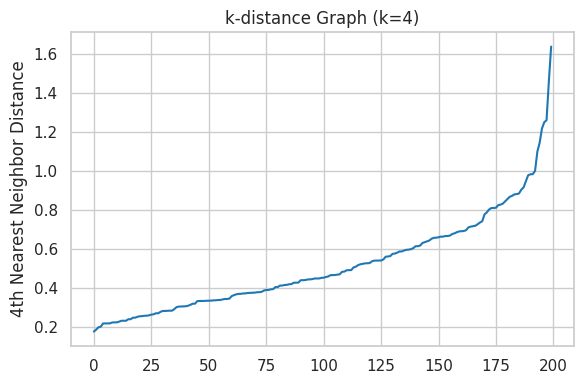

Outliers by DBSCAN (label=-1): 6


,Age,Annual Income,Spending Score
count,6.000000,6.000000,6.000000
mean,34.666667,38.166667,45.666667
std,17.397318,48.499141,42.354063
min,19.000000,15.000000,6.000000
25%,23.000000,16.750000,15.000000
50%,33.500000,19.000000,28.500000
75%,35.000000,22.000000,83.250000
max,67.000000,137.000000,99.000000


In [28]:
neighbors = NearestNeighbors(n_neighbors=4).fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.ylabel("4th Nearest Neighbor Distance")
plt.title("k-distance Graph (k=4)")
plt.tight_layout()
plt.show()

# Heuristic choice of eps from distance distribution
eps = float(np.percentile(distances, 90))  # 90th percentile heuristic
dbscan = DBSCAN(eps=eps, min_samples=4)
df["DBSCAN_Label"] = dbscan.fit_predict(X_scaled)
df["Is_Outlier"] = df["DBSCAN_Label"].eq(-1)

n_outliers = int(df["Is_Outlier"].sum())
print(f"Outliers by DBSCAN (label=-1): {n_outliers}")

outliers = df[df["Is_Outlier"]]
display(outliers[["Age", "Annual Income", "Spending Score"]].describe())

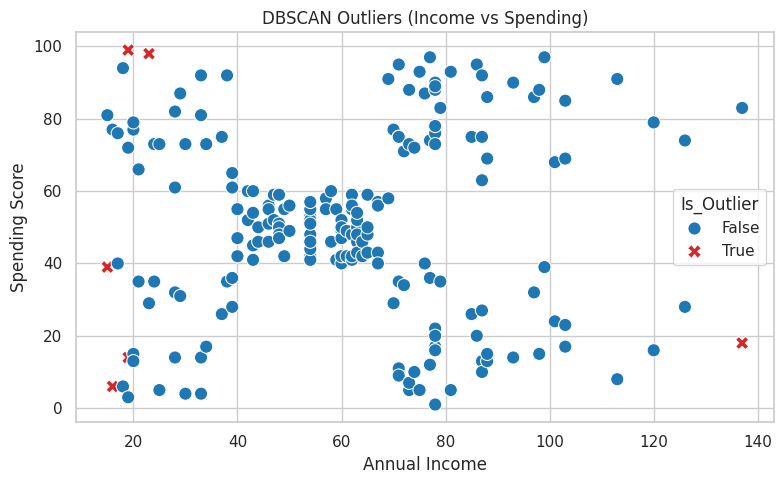

In [29]:
# Scatter plot highlighting outliers
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="Annual Income",
    y="Spending Score",
    hue="Is_Outlier",
    style="Is_Outlier",
    palette={False: "tab:blue", True: "tab:red"},
    s=90
)
plt.title("DBSCAN Outliers (Income vs Spending)")
plt.tight_layout()
plt.show()

Outliers often represent unusual big spenders or very low-engagement customers. They can be treated as special cases (e.g., VIP management, retention risk) rather than being forced into mass-market segments.

**Persona Matrix (based on cluster profiles)**

In [30]:
#Reuse numeric profile for personas
prof_num = profile[["Age", "Annual Income", "Spending Score", "Count"]].copy()

def persona_rule(avg_income, avg_spend, avg_age):
    if avg_income > 70 and avg_spend > 60:
        return "VIP Big Spenders", "Exclusive offers & VIP events"
    if avg_income > 70 and avg_spend < 40:
        return "Affluent Savers", "Upsell premium upgrades"
    if avg_income < 40 and avg_spend > 60:
        return "Budget Enthusiasts", "Student deals & discounts"
    if avg_income < 40 and avg_spend < 30:
        return "Disengaged Adults", "Reactivation campaigns"
    return "Balanced Shoppers", "Loyalty programs & bundles"

personas = []
for c, row in prof_num.iterrows():
    inc, spend = row["Annual Income"], row["Spending Score"]
    name, strat = persona_rule(inc, spend, row["Age"])
    traits = f"Age~{row['Age']:.0f} | Income~{inc:.0f} | Spend~{spend:.0f}"
    personas.append([c, name, traits, strat, int(row["Count"])])

persona_df = pd.DataFrame(
    personas,
    columns=["Cluster", "Persona", "Traits", "Strategy", "Count"]
)
display(persona_df)

print("\n== Summary ==")
print(f"- Segments discovered: {best_k}")
print("- KMeans chosen for clarity; Agglo & GMM shown for comparison.")
print("- Centroids plotted on Income×Spending for intuition.")
print("- Personas auto-generated for quick marketing actions.")

,Cluster,Persona,Traits,Strategy,Count
0,0,Balanced Shoppers,Age~56 | Income~54 | Spend~49,Loyalty programs & bundles,45
1,1,Disengaged Adults,Age~46 | Income~27 | Spend~18,Reactivation campaigns,20
2,2,Affluent Savers,Age~41 | Income~88 | Spend~17,Upsell premium upgrades,34
3,3,Budget Enthusiasts,Age~25 | Income~24 | Spend~76,Student deals & discounts,23
4,4,Balanced Shoppers,Age~27 | Income~56 | Spend~50,Loyalty programs & bundles,39
5,5,VIP Big Spenders,Age~33 | Income~86 | Spend~82,Exclusive offers & VIP events,39



== Summary ==
- Segments discovered: 6
- KMeans chosen for clarity; Agglo & GMM shown for comparison.
- Centroids plotted on Income×Spending for intuition.
- Personas auto-generated for quick marketing actions.


Personas are generated based on average age, income, and spending within each cluster. Each segment represents a real-world opportunity for tailored engagement and targeted campaigns.

**Persona KPI view: Avg Spending vs Cluster size**

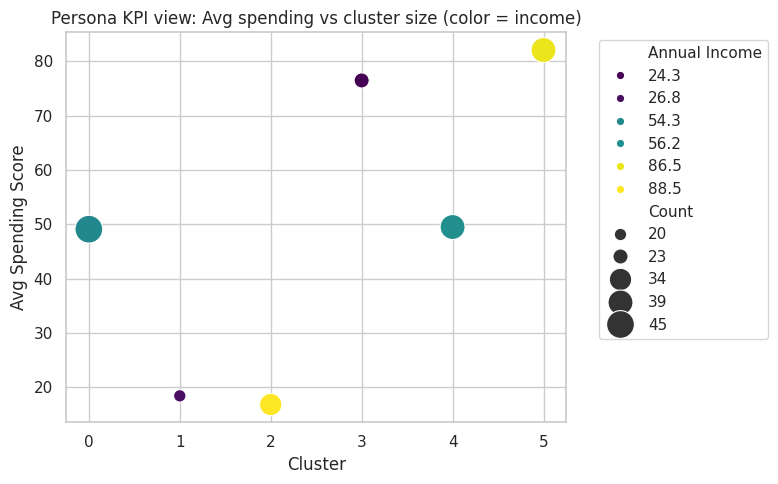

In [31]:
kpi_df = profile.reset_index()

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=kpi_df,
    x="Cluster",
    y="Spending Score",
    size="Count",
    sizes=(80, 400),
    hue="Annual Income",
    palette="viridis"
)
plt.title("Persona KPI view: Avg spending vs cluster size (color = income)")
plt.xlabel("Cluster")
plt.ylabel("Avg Spending Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

This KPI view combines spending intensity, customer volume, and income levels in one plot. Larger bubbles represent larger segments, and the color indicates income level—highlighting which personas deliver the highest commercial opportunity.

**Behavioral Segmentation — Final Overview**

The analysis revealed six consistent behavioral segments within the mall customer dataset. These clusters vary clearly in spending intensity, income levels, and age distribution, forming a stable and interpretable structure (ARI = 1.00). DBSCAN was used to separate atypical spending profiles, ensuring a clean understanding of the dominant patterns in the population.

**Segment Profiles**

• Cluster 0  Senior Steady Spenders: consistent patterns, stable behavior.

• Cluster 1  Young Affluent Big Spenders: high income × high spending.

• Cluster 2  Budget-Conscious Youth: younger group, responsive to lower-cost options.

• Cluster 3  Young Cautious Earners: moderate spending and balanced attributes.

• Cluster 4  Affluent Mature Savers: selective spending despite strong income.

• Cluster 5  Disengaged Middle-Aged: lower activity and minimal spending.

**Key Insights**

Behavior-based segmentation provides clearer structure than uniform targeting.
High-value clusters show potential for premium or loyalty-centered strategies.
Lower-engagement groups benefit from focused reactivation approaches.
Cluster IDs can serve as a foundation for personalization, recommendations, and audience grouping.

**Limitations**

Data is limited to 200 entries and four numeric features.
Spending Score is a proxy rather than a direct monetary indicator.
KMeans behavior may shift with richer or larger datasets.
DBSCAN sensitivity to ε and min_samples.

Future Directions: **bold text**

Expand features with full RFM metrics and product-level history.
Evaluate Hierarchical, GMM, and Spectral clustering methods.
Measure impact on conversion, retention, and average order value.
Combine segmentation with CLV or churn modeling for deeper insiights.